In [1]:
# HW3 in Computational Physics: Molecular Dynamics

In [2]:
# import libraries
import numpy as np
import math
import random as rd
import os
import glob

# for animations
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import matplotlib.pyplot as plt

In [3]:
# implement 2D Maxwellian Distribution
# formula derived from formula given in the instructions to the assignment
def maxwellian_distribution(x_values):
    y = []
    for x in x_values:
        y.append((-Np*math.exp(-2*x)) + Np)
    return y

# plot position and energy distribution at a specific time
def plot_position_and_energy(x_arr, y_arr, E, L, t, r, output_file, show, suptitle):
    plt.figure(figsize=[10, 5], dpi = 150)
    
    # position
    # to display good particle size, inpiration from https://stackoverflow.com/questions/33094509/correct-sizing-of-markers-in-scatter-plot-to-a-radius-r-in-matplotlib
    ax1 = plt.axes([0.075, 0.1, 0.35, 0.7], xlim=(0, L), ylim=(0, L))
    points_whole_ax = 7.5 * ((0.7 + 0.35 - 0.1 - 0.075)/2) * 72    # 1 point = dpi / 72 pixels
    radius = r
    points_radius = [2 * rad / 1.0 * points_whole_ax for rad in radius]
    points_radius_square = [rad**2 for rad in points_radius]
    ax1.scatter(x_arr, y_arr, s=points_radius_square)
    ax1.set_title("Particles positions at time t = %i"%(t))
    ax1.set_ylabel("y")
    ax1.set_xlabel("x")
    ax1.set_aspect('equal')
    
    # energy distribution
    # get x_E and y_E array to plot the maxwellian_distribution distribution
    x_E = []
    x_E_val = 0
    while x_E_val < max(E) or x_E_val < 1:
        x_E.append(x_E_val)
        x_E_val += 0.1
    y_E = maxwellian_distribution(x_E)
    
    ax2 = plt.axes([0.5, 0.1, 0.475, 0.7])
    ax2.hist([round(i, 5) for i in E], cumulative=True, label='Empirical', color = 'lightblue', bins = 50)
    ax2.plot(x_E, y_E, 'k--', linewidth=1.5, label='Theoretical')
    ax2.grid()
    ax2.set_title("Cumulative Energy Distribution of particles at t = %i"%(t))
    ax2.legend(loc = 'upper left')
    ax2.set_ylabel("Count")
    ax2.set_xlabel("Energy of Particles")
    
    plt.suptitle(suptitle, y=0.93, fontweight = 'bold')
    plt.savefig(output_file)
    if show:
        plt.show()
    else:
        plt.close()

# implement Euler method to update particles' position
def Euler_method(x, y, Vx, Vy, dt):
    x_prime = x + Vx * dt
    y_prime = y + Vy * dt
    return x_prime, y_prime

# create animation with moviepy library
def create_animation(folder_path, Nt, x, y, E, fps, r, output_file, suptitle):
    # create folder in which we will store all images and the animation
    tmp_folder = folder_path + "/tmp"
    if os.path.exists(tmp_folder):
        files = glob.glob(tmp_folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(tmp_folder)
    
    # create the individual images
    for nt in range(Nt):
        plot_position_and_energy(x[nt], y[nt], E[nt], L, nt, r, tmp_folder + "/" + str(nt) + ".png", False, suptitle)
    
    file_list = np.array(sorted(glob.glob(tmp_folder + '/*.png')))
    order = np.array([int(f.split("/")[-1].split(".")[0]) for f in file_list])
    sortIx = np.argsort(order)
    file_list = list(file_list[sortIx])

    clip = mpy.ImageSequenceClip(file_list, fps=fps)
    clip.write_videofile(folder_path + "/" + output_file)

In [4]:
# implement REFLECTIVE boundary conditions
# we take into account the particles' radius: 
    # since the position of the particle is the position of its center
    # it may be the case that, for example, for the left boundary, the x position is still positive
    # but a tiny part of the ball is outside the box
def reflective_BC(Np, x, y, Vx, Vy, r):
    for n in range(Np): # for each particle
        if x[n] < 0 + r[n]: # left boundary
            if x[n] > 0: # case where the value of x is sill positive but < the particle radius
                x[n] = r[n] + (r[n] - x[n])
            else:
                x[n] = -x[n] + r[n]
            Vx[n] = - Vx[n]
        if x[n] > L - r[n]: # right boundary
            if x[n] < L: # case where the value of x is sill < L but > (L - radius of particle)
                x[n] = L - r[n] - (x[n] - (L - r[n]))
            else:
                x[n] = L - (x[n] - L) - r[n]
            Vx[n] = - Vx[n]
        if y[n] < 0 + r[n]: # lower boundary
            if y[n] > 0: # case where the value of y is sill positive but < the particle radius
                y[n] = r[n] + (r[n] - y[n])
            else:
                y[n] = -y[n] + r[n]
            Vy[n] = - Vy[n]
        if y[n] > L - r[n]: # upper boundary
            if y[n] < L: # case where the value of y is sill < L but > (L - radius of particle)
                y[n] = L - r[n] - (y[n] - (L - r[n]))
            else:
                y[n] = L - (y[n] - L) - r[n]
            Vy[n] = - Vy[n]
    return x, y, Vx, Vy

# implement PERIODIC boundary conditions
def periodic_BC(Np, x, y, Vx, Vy):
    for n in range(Np): # for each particle
        if x[n] < 0: # left boundary
            x[n] = L + x[n]
        if x[n] > L: # right boundary
            x[n] = x[n] - L
        if y[n] < 0: # lower boundary
            y[n] = L + y[n]
        if y[n] > L: # upper boundary
            y[n] = y[n] - L
    return x, y, Vx, Vy

# handles collisions conserving momentum and energy and assuming the colliding particles receive a kick in random directions
def handle_collisions(Np, x, y, Vx, Vy, r, m, x_prev, y_prev):
    for n1 in range(Np):
        for n2 in range(n1 + 1, Np):
            sep = math.sqrt((x[n1] - x[n2])**2 + (y[n1] - y[n2])**2)
            # make sure there was no collision in the last timestep
            sep_prev = math.sqrt((x_prev[n1] - x_prev[n2])**2 + (y_prev[n1] - y_prev[n2])**2)
            
            if sep <= r[n1] + r[n2] and sep < sep_prev:
                # collision happened!
                # based on formulas seen in class
                v_const_x = (m[n1] * Vx[n1] + m[n2] * Vx[n2])/(m[n1] + m[n2])
                v_const_y = (m[n1] * Vy[n1] + m[n2] * Vy[n2])/(m[n1] + m[n2])

                mu = (m[n1] * m[n2])/(m[n1] + m[n2])

                v_rel_x = Vx[n1] - Vx[n2]
                v_rel_y = Vy[n1] - Vy[n2]
                v_rel_len = math.sqrt(v_rel_x**2 + v_rel_y**2)

                # choose random angles
                alpha_n1 = rd.uniform(0, 2*math.pi)
                alpha_n2 = rd.uniform(0, 2*math.pi)

                Vx[n1] = v_const_x + ((mu/m[n1]) * v_rel_len * math.cos(alpha_n1))
                Vx[n2] = v_const_x - ((mu/m[n2]) * v_rel_len * math.cos(alpha_n2))

                Vy[n1] = v_const_y + ((mu/m[n1]) * v_rel_len * math.sin(alpha_n1))
                Vy[n2] = v_const_y - ((mu/m[n2]) * v_rel_len * math.sin(alpha_n2))
    return x, y, Vx, Vy

def calculate_particles_velocities(Np, Vx, Vy):
    V = []
    for n in range(Np):
        V.append(math.sqrt(Vx[n]**2 + Vy[n]**2))
    return V 

def calculate_particles_energies(Np, m, V):
    E = []
    for n in range(Np):
        E.append((1/2) * m[n] * (V[n]**2))
    return E

In [5]:
def run_simulation(Nt, Epsilon, boundary_condition, x, y, V, Vx, Vy, E, m, r):
    for N in range(1, Nt):
        # calculate timestep
        dt = Epsilon * min(r) * max(V[N-1])

        # update position (Euler method) for all particlles
        x_tmp = []
        y_tmp = []
        for n in range(Np):
            x_new, y_new = Euler_method(x[N-1][n], y[N-1][n], Vx[N-1][n], Vy[N-1][n], dt)
            x_tmp.append(x_new)
            y_tmp.append(y_new)
        # for now, the speed is unchanged
        Vx_tmp = Vx[N-1]
        Vy_tmp = Vy[N-1]

        if N == 1:
            x_prev = x_tmp
            y_prev = y_tmp

        # check for collisions and update positions and velocities if collisions happened
        x_tmp, y_tmp, Vx_tmp, Vy_tmp = handle_collisions(Np, x_tmp, y_tmp, Vx_tmp, Vy_tmp, r, m, x_prev, y_prev)

        # check for boundary conditions and update positions and velocities necessary
        if boundary_condition == "reflective":
            x_tmp, y_tmp, Vx_tmp, Vy_tmp = reflective_BC(Np, x_tmp, y_tmp, Vx_tmp, Vy_tmp, r)
        elif boundary_condition == "periodic":
            x_tmp, y_tmp, Vx_tmp, Vy_tmp = periodic_BC(Np, x_tmp, y_tmp, Vx_tmp, Vy_tmp)

        # get velocity of each particle
        V_tmp = calculate_particles_velocities(Np, Vx_tmp, Vy_tmp)

        # get kinetic energy of each particle
        E_tmp = calculate_particles_energies(Np, m, V_tmp)

        # store new positions, velocities and energies in arrays
        x.append(x_tmp)
        y.append(y_tmp)
        Vx.append(Vx_tmp)
        Vy.append(Vy_tmp)
        V.append(V_tmp)
        E.append(E_tmp)

        x_prev = x_tmp
        y_prev = y_tmp
    return x, y, V, Vx, Vy, E, m, r

## Case 1: all particles have:
- non-dimensional mass of 1 
- initial velocity of 1
- radius of 0.02

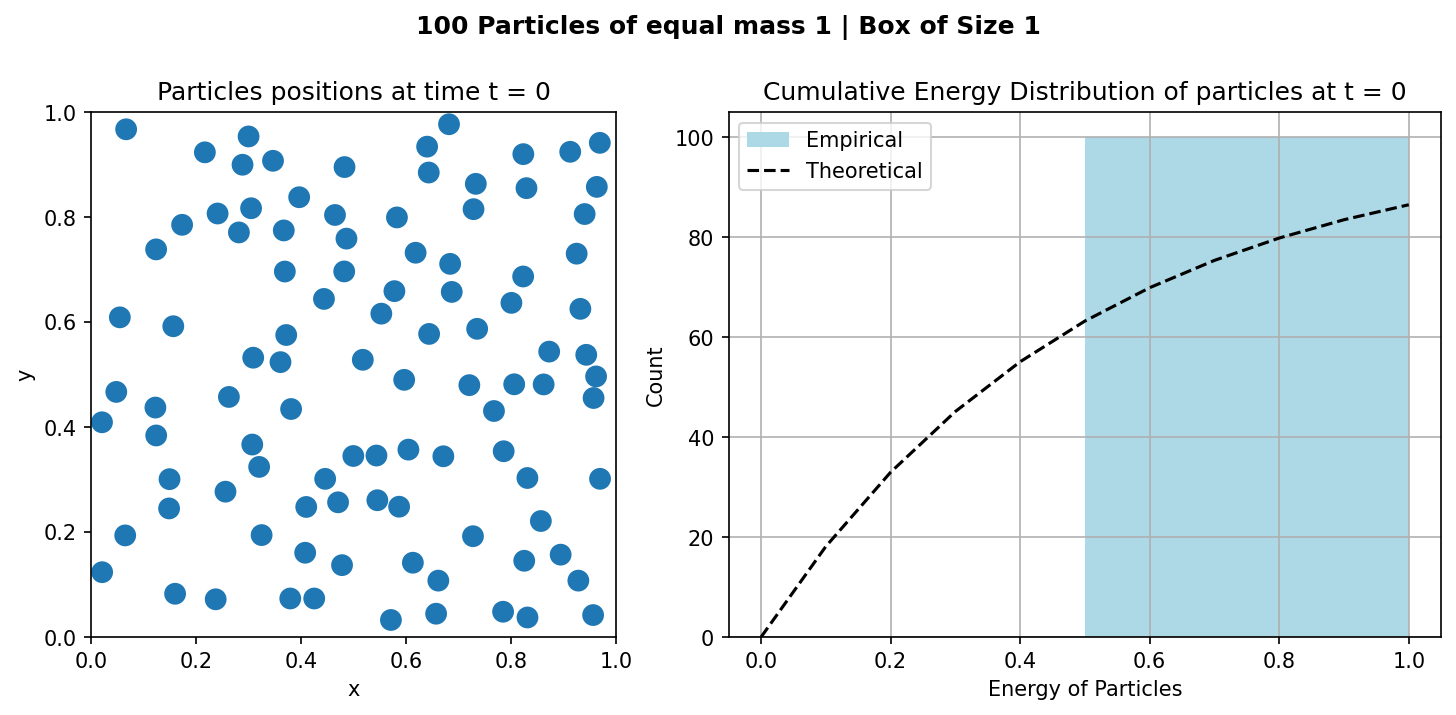

In [6]:
# initialization
Np = 100 # number of particles
Nt = 200 # number of timesteps
L = 1 # box size (square)
suptitle = "%i Particles of equal mass %i | Box of Size %i"%(Np, 1, L)
rd.seed(5)
folder = "case_1"
Epsilon = 0.5 # to generate timestep
boundary_condition = "reflective" # OR "periodic"

m = [] # particles' masses
r = [] # particles' radius
x = [[]] # particles' x positions (example: x[0] has length Np, all x positions at time 0)
y = [[]] # particles' y positions
V = [[]] # particles' velocities 
Vx = [[]] # particles' x-components of velocity
Vy = [[]] # particles' y-components of velocity
E = [[]] # particles' energies

for n in range(Np):
    m.append(1)
    r.append(0.02*L)
    
    # initialize random positions in the box
    x[0].append(rd.uniform(0 + r[-1], L - r[-1]))
    y[0].append(rd.uniform(0 + r[-1], L - r[-1]))
    
    # check that all particles are located at DIFFERENT random positions (do no overlap)
    valid_position = False
    while valid_position == False:
        check = True
        for i in range(len(x[0]) - 1): # check with all other particles
            if (abs(x[0][i] - x[0][-1]) < r[i] + r[-1]) and (abs(y[0][i] - y[0][-1]) < r[i] + r[-1]):
                check = False
                break
        if check == False:
            x[0][-1] = rd.uniform(0 + r[-1], L - r[-1])
            y[0][-1] = rd.uniform(0 + r[-1], L - r[-1])
        else: 
            valid_position = True
    
    # initialize random velocity components (for non dimentional velocity of 1)
    angle = rd.uniform(0, 2*math.pi)
    V[0].append(1)
    Vx[0].append(math.cos(angle) * V[0][-1])
    Vy[0].append(math.sin(angle) * V[0][-1])
    
    # initialize kinetic energy E
    E[0].append((1/2) * m[n] * (V[0][n]**2))

plot_position_and_energy(x[0], y[0], E[0], L, 0, r, folder + "/initial_state.png",  True, suptitle)

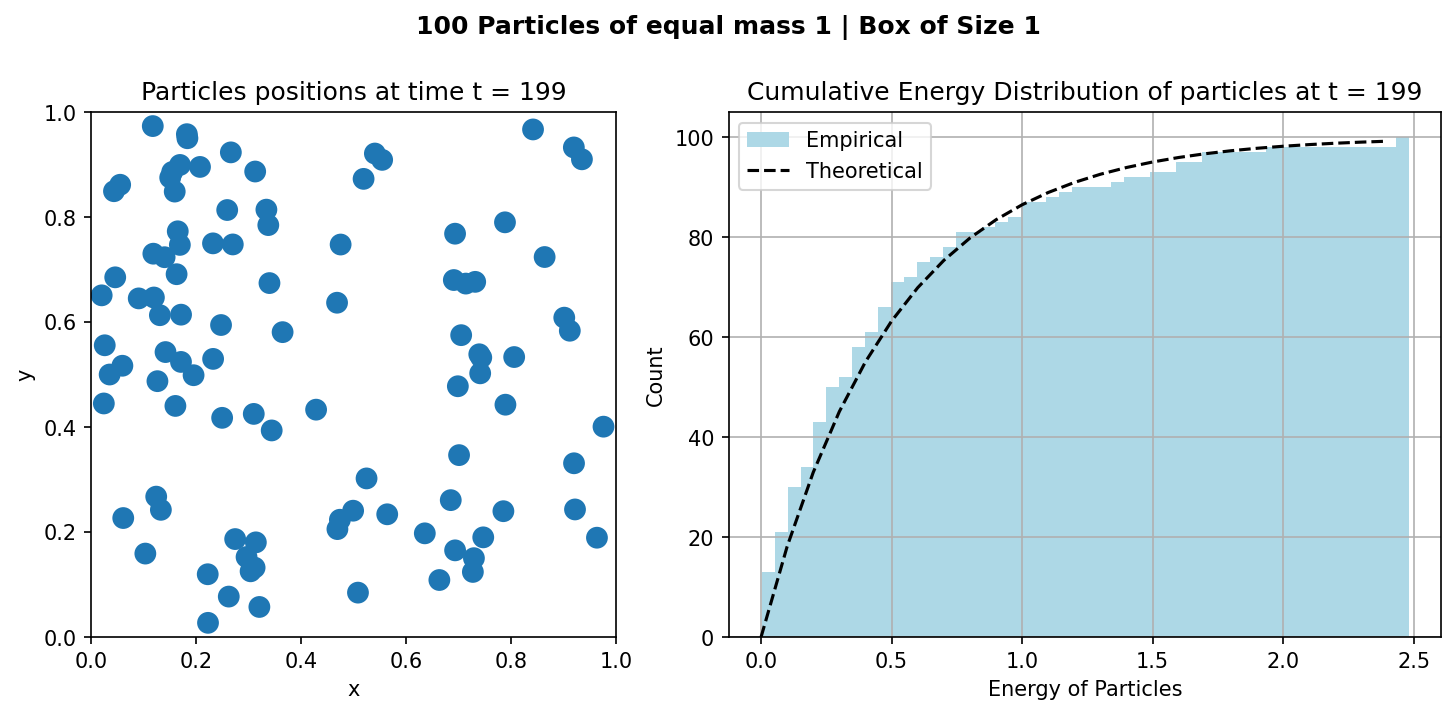

In [7]:
x, y , V, Vx, Vy, E, m, r = run_simulation(Nt, Epsilon, boundary_condition, x, y, V, Vx, Vy, E, m, r)

plot_position_and_energy(x[-1], y[-1], E[-1], L, 199, r, folder + "/final_state.png",  True, suptitle)

In [8]:
fps = 20
create_animation(folder, Nt, x, y, E, fps, r, 'animation_case_1.mp4', suptitle)      

Moviepy - Building video case_1/animation_case_1.mp4.
Moviepy - Writing video case_1/animation_case_1.mp4



Moviepy - Done !
Moviepy - video ready case_1/animation_case_1.mp4


 ## Case 2:
- half of the particles have a non-dimensional mass of 1 and initial non- dimensional velocity of 1
- half of the particles have a non-dimensional mass of 10 and initial non-dimensional velocity of sqrt(1/10)
- all particles have a radius of 0.02

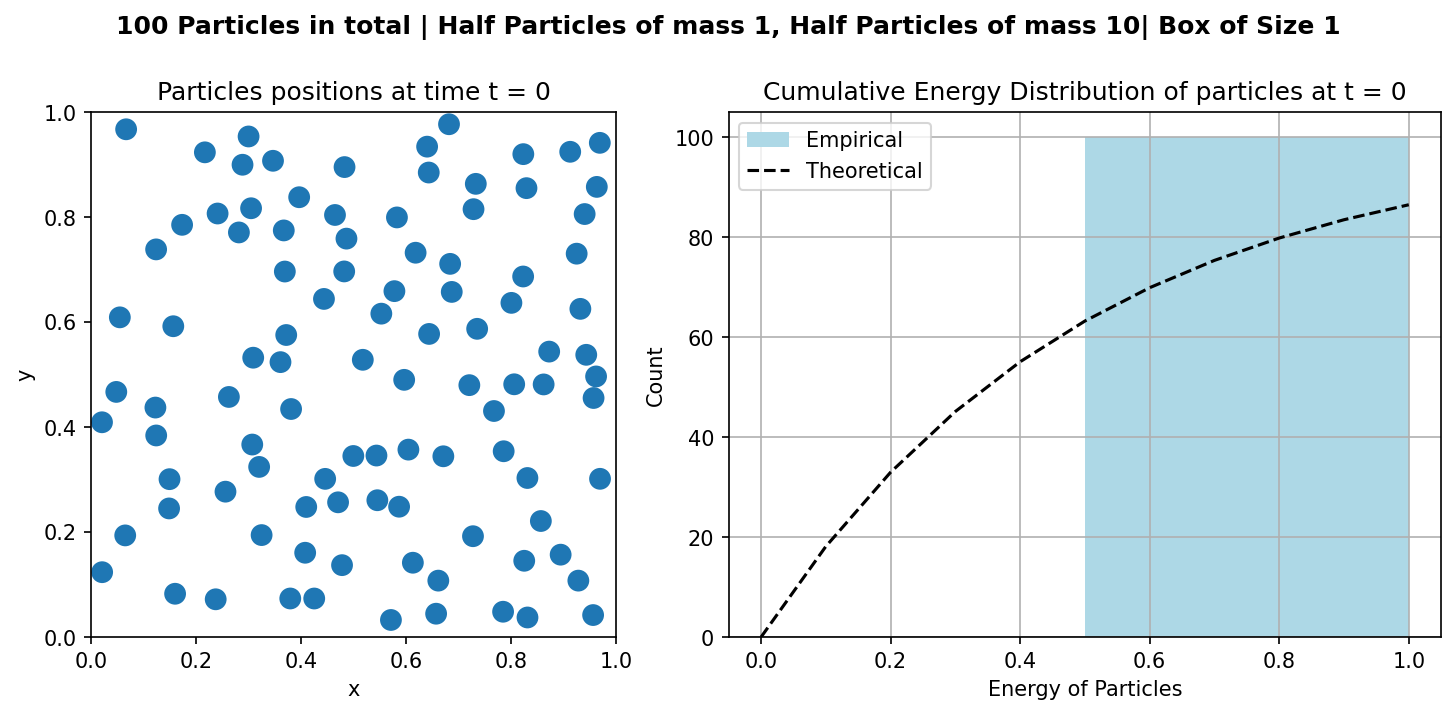

In [12]:
# initialization
Np = 100 # number of particles
Nt = 200 # number of timesteps
L = 1 # box size (square)
suptitle = "%i Particles in total | Half Particles of mass %i, Half Particles of mass %i| Box of Size %i"%(Np, 1, 10, L)
rd.seed(5)
folder = "case_2"
Epsilon = 0.5 # to generate timestep
boundary_condition = "reflective" # periodic

m = [] # particles' masses
r = [] # particles' radius
x = [[]] # particles' x positions (example: x[0] has length Np, all x positions at time 0)
y = [[]] # particles' y positions
V = [[]] # particles' velocities 
Vx = [[]] # particles' x-components of velocity
Vy = [[]] # particles' y-components of velocity
E = [[]] # particles' energies

for n in range(Np):
    # case 2:
    if n < Np/2:
        m.append(1)
    else:
        m.append(10)
    r.append(0.02*L)
    
    # initialize random positions in the box
    x[0].append(rd.uniform(0 + r[-1], L - r[-1]))
    y[0].append(rd.uniform(0 + r[-1], L - r[-1]))
    
    valid_position = False
    while valid_position == False:
        check = True
        for i in range(len(x[0]) - 1): # check with all other particles
            if (abs(x[0][i] - x[0][-1]) < r[i] + r[-1]) and (abs(y[0][i] - y[0][-1]) < r[i] + r[-1]):
                check = False
                break
        if check == False:
            x[0][-1] = rd.uniform(0 + r[-1], L - r[-1])
            y[0][-1] = rd.uniform(0 + r[-1], L - r[-1])
        else: 
            valid_position = True
    
    # initialize random velocity components (for non dimentional velocity of 1)
    angle = rd.uniform(0, 2*math.pi)
    if n < Np/2:
        V[0].append(1)
        Vx[0].append(math.cos(angle))
        Vy[0].append(math.sin(angle))
    else:
        V[0].append(math.sqrt(1/10))
        Vx[0].append(math.cos(angle) * V[0][-1])
        Vy[0].append(math.sin(angle) * V[0][-1])
        
    
    # initialize kinetic energy E
    E[0].append((1/2) * m[n] * V[0][n]**2)

plot_position_and_energy(x[0], y[0], E[0], L, 0, r, folder + "/initial_state.png",  True, suptitle)

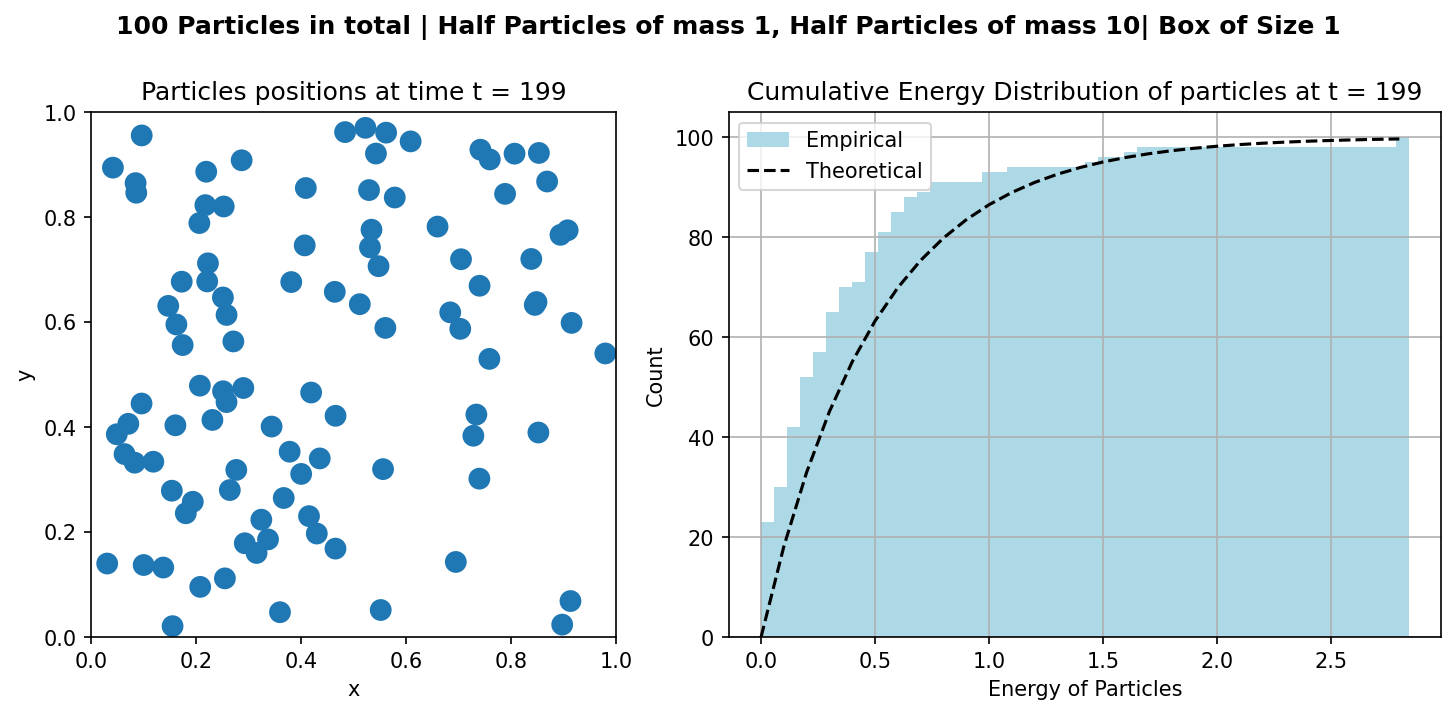

In [13]:
x, y , V, Vx, Vy, E, m, r = run_simulation(Nt, Epsilon, boundary_condition, x, y, V, Vx, Vy, E, m, r)

plot_position_and_energy(x[-1], y[-1], E[-1], L, 199, r, folder + "/final_state.png",  True, suptitle)

In [14]:
fps = 20
create_animation(folder, Nt, x, y, E, fps, r, 'animation_case_2.mp4', suptitle)       

Moviepy - Building video case_2/animation_case_2.mp4.
Moviepy - Writing video case_2/animation_case_2.mp4



Moviepy - Done !
Moviepy - video ready case_2/animation_case_2.mp4
